In [1]:
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split  # 数据集划分

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [2]:
class ObesityDataPreprocessor:
    """
    肥胖水平数据集专用预处理类
    功能：数据加载、缺失值处理、无关列删除、分类变量编码、数据集划分
    """
    def __init__(self):
        self.raw_data = None          # 原始数据
        self.cleaned_data = None      # 清洗后的数据
        self.label_encoders = {}      # 保存所有列的编码器
        self.X = None                 # 特征矩阵（编码后）
        self.y = None                 # 目标变量（编码后）
        self.X_train = None           # 训练集特征
        self.X_test = None            # 测试集特征
        self.y_train = None           # 训练集标签
        self.y_test = None            # 测试集标签   
        
        self.target_column = '0be1dad'  # 目标变量列名（肥胖水平）
        self.drop_cols = ['id', 'Weight', 'Height']  # 需删除的无关列
        self.categorical_cols = [       # 需编码的分类变量列名
            'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
            'SMOKE', 'SCC', 'CALC', 'MTRANS'
        ]
    
    def load_data(self, data_path):
        """
        加载CSV格式数据（含异常处理）
        :param data_path: 数据文件路径（绝对路径或相对路径）
        :raise FileNotFoundError: 文件不存在时抛出
        :raise ValueError: 文件格式非CSV时
        """
        try:
            # 校验文件格式
            if not data_path.endswith('.csv'):
                raise ValueError("仅支持CSV格式数据，请检查文件后缀")
            
            # 读取数据
            self.raw_data = pd.read_csv(data_path)

        except FileNotFoundError:
            raise FileNotFoundError(f"错误：找不到文件 '{data_path}'，请检查路径是否正确")
    
    def handle_missing_values(self):
        """
        处理缺失值（删除含缺失值的行）
        """ 
        missing_sum = self.raw_data.isnull().sum().sum()
        if missing_sum == 0:
            self.cleaned_data = self.raw_data.copy()
            print("数据集中无缺失值，无需删除")
        else:
            # 删除含缺失值的行
            self.cleaned_data = self.raw_data.dropna()
            print(f"缺失值处理完成：原始数据 {self.raw_data.shape} → 清洗后 {self.cleaned_data.shape}")
            print(f"删除的缺失值总数：{missing_sum}")
    
    def drop_irrelevant_cols(self):
        """
        删除无关列（id、Weight、Height）
        """
        # 校验待删除列是否存在
        existing_drop_cols = [col for col in self.drop_cols if col in self.cleaned_data.columns]       
        self.cleaned_data = self.cleaned_data.drop(columns=existing_drop_cols, axis=1)
        print(f"剩余列名：{list(self.cleaned_data.columns)}")
    
    def encode_categorical_variables(self):
        """
        对分类变量和目标变量进行标签编码（LabelEncoder）
        """
        # 1. 编码分类特征列
        for col in self.categorical_cols:
            try:
                if col not in self.cleaned_data.columns:
                    print(f"警告：分类列 '{col}' 不存在于数据中，跳过编码")
                    continue
                
                le = LabelEncoder()
                # 确保列数据为字符串类型
                self.cleaned_data[col] = le.fit_transform(self.cleaned_data[col].astype(str))
                self.label_encoders[col] = le  # 保存编码器
                print(f"列 '{col}' 编码完成，类别映射：{dict(zip(le.classes_, le.transform(le.classes_)))}")
            
            except Exception as e:
                raise RuntimeError(f"列 '{col}' 编码失败：{str(e)}")
        
        # 2. 编码目标变量（肥胖水平）
        try:
            if self.target_column not in self.cleaned_data.columns:
                raise KeyError(f"目标列 '{self.target_column}' 不存在于数据中")
            
            le_target = LabelEncoder()
            self.cleaned_data[self.target_column] = le_target.fit_transform(
                self.cleaned_data[self.target_column].astype(str)
            )
            self.label_encoders[self.target_column] = le_target  # 保存目标变量编码器
            print(f"\n目标列 '{self.target_column}' 编码完成，类别映射：{dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
            
            # 输出目标变量分布
            target_dist = pd.Series(self.cleaned_data[self.target_column]).value_counts().sort_index()
            print(f"\n目标变量（肥胖水平）样本分布：")
            print(target_dist)
        
        except KeyError as ke:
            raise KeyError(f"目标变量编码失败：{str(ke)}")
        except Exception as e:
            raise RuntimeError(f"目标变量编码失败：{str(e)}")
    
    def split_train_test(self, test_size=0.2, random_state=42, stratify=True):
        """
        划分训练集和测试集
        :param test_size: 测试集比例（默认0.2）
        :param random_state: 随机种子（保证可复现，默认42）
        :param stratify: 是否按目标变量分布分层（默认True，避免数据偏斜）
        """       
        # 分离特征和目标变量
        self.X = self.cleaned_data.drop(columns=[self.target_column], axis=1)
        self.y = self.cleaned_data[self.target_column]
        
        # 划分数据集
        stratify_param = self.y if stratify else None
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=stratify_param
        )
        
        print(f"\n数据集划分完成：")
        print(f"训练集特征形状：{self.X_train.shape}")
        print(f"测试集特征形状：{self.X_test.shape}")
        print(f"训练集标签形状：{self.y_train.shape}")
        print(f"测试集标签形状：{self.y_test.shape}")
    
    def run_full_preprocess(self, data_path, test_size=0.2, random_state=42):
        """
        执行完整预处理流程
        :param data_path: 数据文件路径
        :param test_size: 测试集比例
        :param random_state: 随机种子
        :return: X, y, X_train, X_test, y_train, y_test, label_encoders
        """
        # 按顺序调用内部方法（流程化执行）
        self.load_data(data_path)
        self.handle_missing_values()
        self.drop_irrelevant_cols()
        self.encode_categorical_variables()
        self.split_train_test(test_size=test_size, random_state=random_state)

        # 返回建模所需的核心结果
        return self.X, self.y, self.X_train, self.X_test, self.y_train, self.y_test, self.label_encoders

In [3]:
preprocessor = ObesityDataPreprocessor()
X, y, X_train, X_test, y_train, y_test, encoders = preprocessor.run_full_preprocess(
            data_path="D:/workdata/obesity_level.csv", 
            test_size=0.25,  # 测试集占比25%
            random_state=42  # 固定随机种子，保证可复现
        )

数据集中无缺失值，无需删除
剩余列名：['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', '0be1dad']
列 'Gender' 编码完成，类别映射：{'Female': np.int64(0), 'Male': np.int64(1)}
列 'family_history_with_overweight' 编码完成，类别映射：{'0': np.int64(0), '1': np.int64(1)}
列 'FAVC' 编码完成，类别映射：{'0': np.int64(0), '1': np.int64(1)}
列 'CAEC' 编码完成，类别映射：{'0': np.int64(0), 'Always': np.int64(1), 'Frequently': np.int64(2), 'Sometimes': np.int64(3)}
列 'SMOKE' 编码完成，类别映射：{'0': np.int64(0), '1': np.int64(1)}
列 'SCC' 编码完成，类别映射：{'0': np.int64(0), '1': np.int64(1)}
列 'CALC' 编码完成，类别映射：{'0': np.int64(0), 'Frequently': np.int64(1), 'Sometimes': np.int64(2)}
列 'MTRANS' 编码完成，类别映射：{'Automobile': np.int64(0), 'Bike': np.int64(1), 'Motorbike': np.int64(2), 'Public_Transportation': np.int64(3), 'Walking': np.int64(4)}

目标列 '0be1dad' 编码完成，类别映射：{'0rmal_Weight': np.int64(0), 'Insufficient_Weight': np.int64(1), 'Obesity_Type_I': np.int64(2), 'Obesity_Type_II': np.int64(3)

        count     mean     std   min     25%      50%      75%   max
Age   20758.0  23.8418  5.6881  14.0  20.000  22.8154  26.0000  61.0
FCVC  20758.0   2.4459  0.5332   1.0   2.000   2.3938   3.0000   3.0
NCP   20758.0   2.7613  0.7054   1.0   3.000   3.0000   3.0000   4.0
CH2O  20758.0   2.0294  0.6085   1.0   1.792   2.0000   2.5496   3.0
FAF   20758.0   0.9817  0.8383   0.0   0.008   1.0000   1.5874   3.0
TUE   20758.0   0.6168  0.6021   0.0   0.000   0.5739   1.0000   2.0
                              变量名  众数  众数出现次数  中位数  下四分位数(Q1)  上四分位数(Q3)  \
0                          Gender   0   10422  0.0        0.0        1.0   
1  family_history_with_overweight   1   17014  1.0        1.0        1.0   
2                            FAVC   1   18982  1.0        1.0        1.0   
3                            CAEC   3   17529  3.0        3.0        3.0   
4                           SMOKE   0   20513  0.0        0.0        0.0   
5                             SCC   0   20071  0.0        0.0

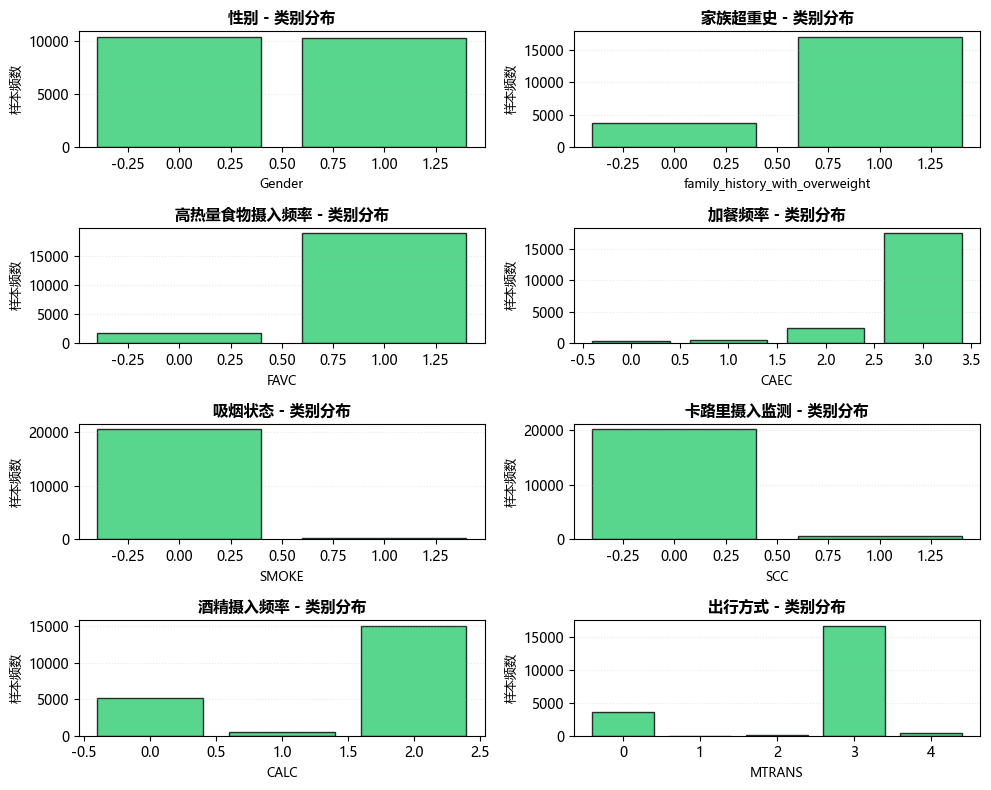

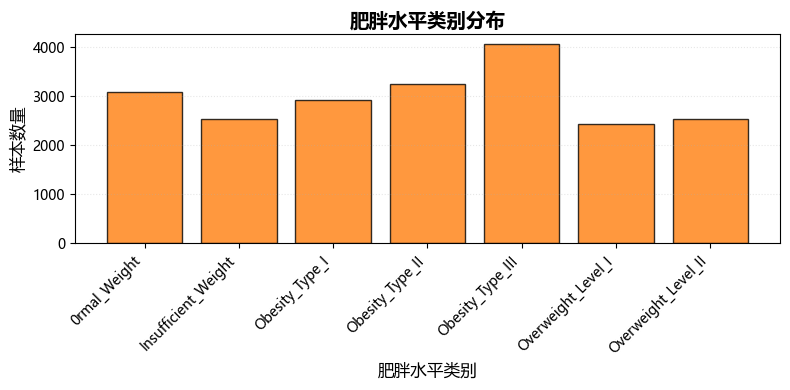

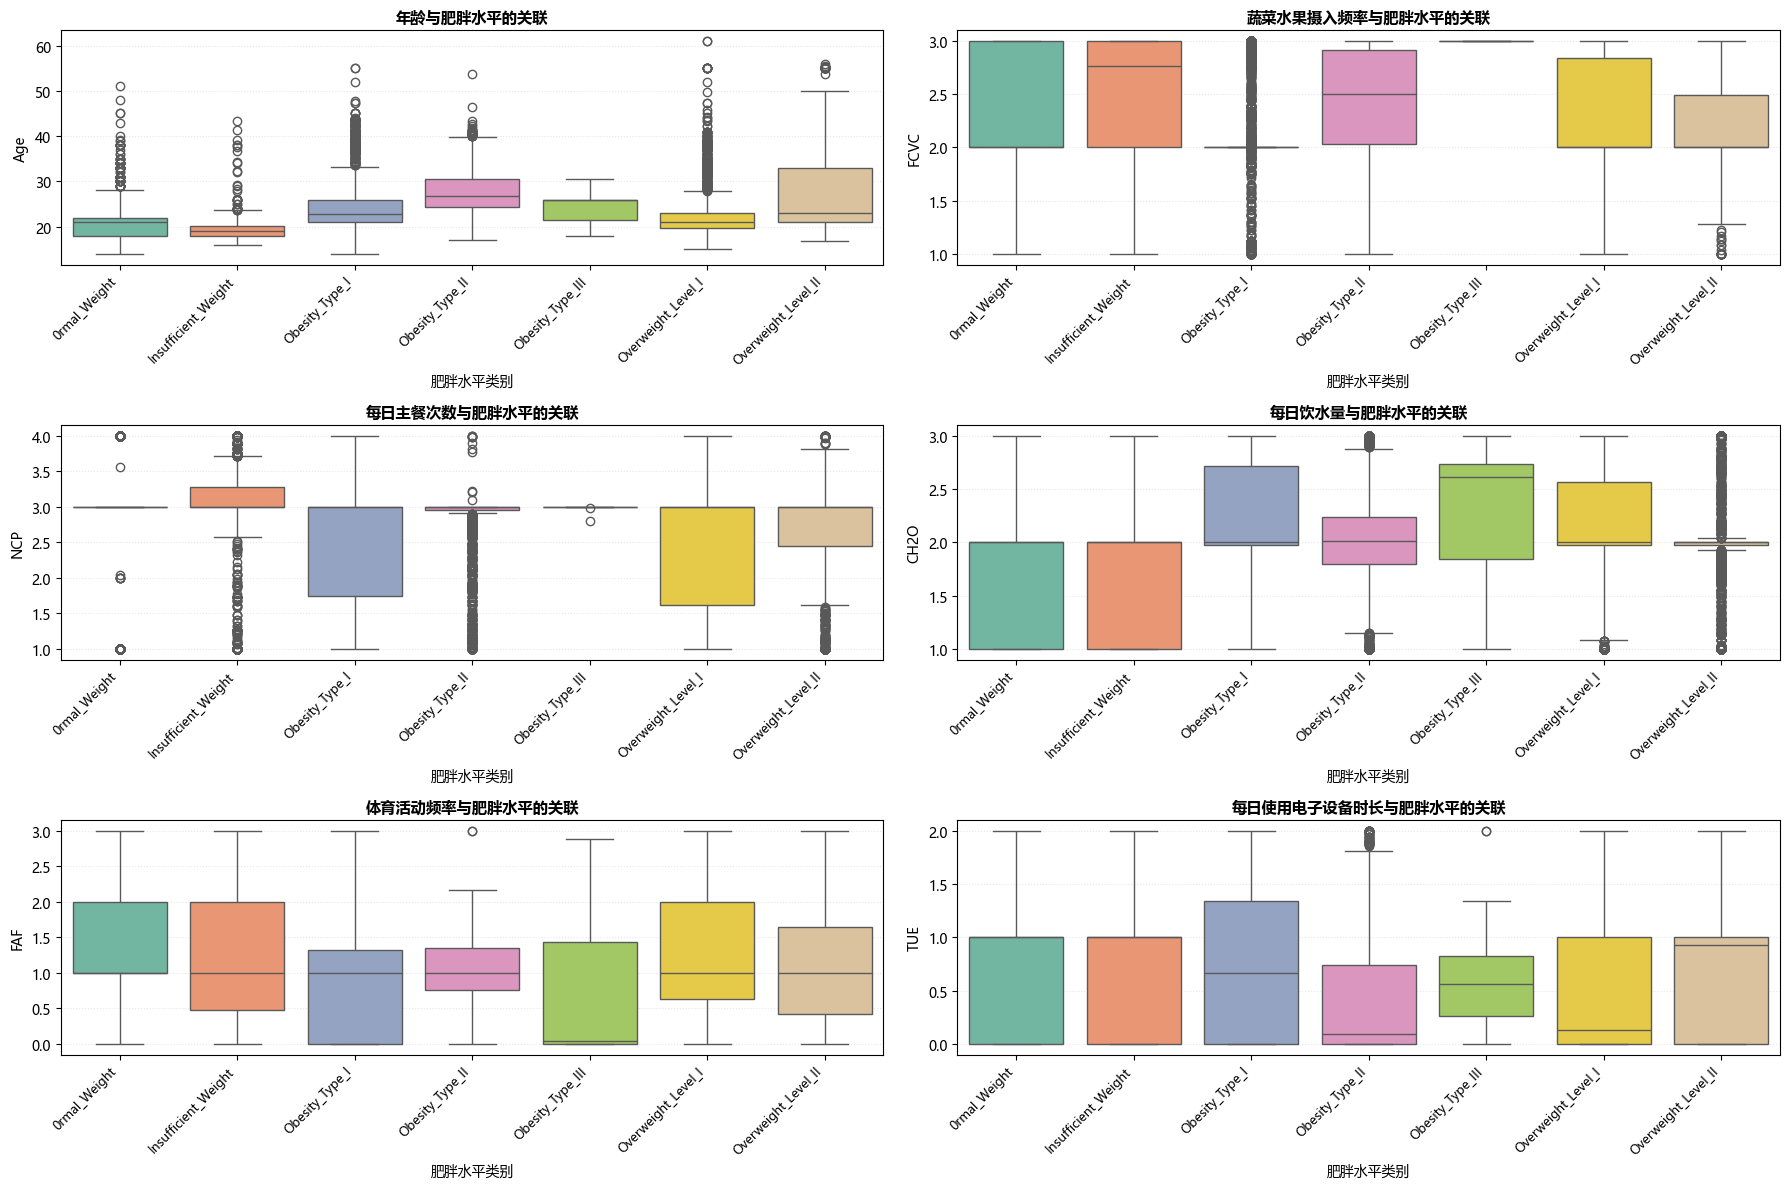

In [32]:
# 描述性统计
# 肥胖数据集列名映射字典
obesity_column_name_dict = {
    'id': '样本编号',
    'Gender': '性别',
    'Age': '年龄',
    'Height': '身高',
    'Weight': '体重',
    'family_history_with_overweight': '家族超重史',
    'FAVC': '高热量食物摄入频率',
    'FCVC': '蔬菜水果摄入频率',
    'NCP': '每日主餐次数',
    'CAEC': '加餐频率',
    'SMOKE': '吸烟状态',
    'CH2O': '每日饮水量',
    'SCC': '卡路里摄入监测',
    'FAF': '体育活动频率',
    'TUE': '每日使用电子设备时长',
    'CALC': '酒精摄入频率',
    'MTRANS': '出行方式',
    '0be1dad': '肥胖等级'
}
class ObesityFullDataDescriptiveAnalysis:
    """
    肥胖数据集描述性统计分析类
    """
    def __init__(self, X, y, encoders, target_column, categorical_cols):
        self.X = X  # 特征矩阵
        self.y = y  # 目标变量
        self.encoders = encoders  # 标签编码器
        self.target_column = target_column  # 目标列名
        self.categorical_cols = categorical_cols  # 分类型特征列名
        # 合并全量特征和目标变量
        self.full_data = pd.concat([self.X, self.y.rename(self.target_column)], axis=1)
        # 筛选连续型（数值型）特征
        self.continuous_cols = [
            col for col in self.full_data.columns 
            if col not in self.categorical_cols
        ]
        # 纯连续型特征（排除目标列）
        self.numerical_cols = [
            col for col in self.full_data.columns 
            if col not in self.categorical_cols and col != self.target_column
        ]

    def continuous_vars_statistics(self):
        """
        计算连续型变量的基础描述性统计量
        :return: 连续型变量统计结果DataFrame
        """
        # 连续型变量基础统计（count/mean/std/min/max/分位数等）
        continuous_stats = self.full_data[self.numerical_cols].describe().T
        print(continuous_stats.round(4))
        return continuous_stats

    def categorical_vars_statistics(self):
        """
        计算分类型变量的统计量：众数、中位数、上下四分位数、四分位差、异众比率
        :return: 分类型变量统计结果DataFrame
        """
        # 初始化统计结果字典
        categorical_stats_dict = {
            '变量名': [],
            '众数': [],
            '众数出现次数': [],
            '中位数': [],
            '下四分位数(Q1)': [],
            '上四分位数(Q3)': [],
            '四分位差(IQR)': [],
            '异众比率': []
        }

        for col in self.categorical_cols:
            # 获取当前分类变量的系列数据
            series_data = self.full_data[col]
            total_count = len(series_data)  # 总样本数（含缺失值则用count()）
            valid_count = series_data.count()  # 有效样本数（排除缺失值）

            # 1. 众数计算
            mode_info = series_data.mode()
            mode_value = mode_info.iloc[0] if not mode_info.empty else np.nan
            mode_count = (series_data == mode_value).sum()

            # 2. 中位数、上下四分位数
            median_value = series_data.median()
            q1_value = series_data.quantile(0.25)
            q3_value = series_data.quantile(0.75)

            # 3. 四分位差（IQR = Q3 - Q1）
            iqr_value = q3_value - q1_value

            # 4. 异众比率 = (总有效样本数 - 众数出现次数) / 总有效样本数
            if valid_count == 0:
                dissimilar_ratio = np.nan
            else:
                dissimilar_ratio = (valid_count - mode_count) / valid_count

            # 将结果填入字典
            categorical_stats_dict['变量名'].append(col)
            categorical_stats_dict['众数'].append(mode_value)
            categorical_stats_dict['众数出现次数'].append(mode_count)
            categorical_stats_dict['中位数'].append(median_value)
            categorical_stats_dict['下四分位数(Q1)'].append(q1_value)
            categorical_stats_dict['上四分位数(Q3)'].append(q3_value)
            categorical_stats_dict['四分位差(IQR)'].append(iqr_value)
            categorical_stats_dict['异众比率'].append(dissimilar_ratio)

        # 转换为DataFrame
        categorical_stats = pd.DataFrame(categorical_stats_dict)
        print(categorical_stats.round(4))
        return categorical_stats

    def plot_categorical_bar(self, figsize=(10, 8)):
        """
        对分类型数据绘制条形图，展示各类别样本分布
        :param figsize: 图形大小
        """
        n_cols = 2
        n_rows = (len(self.categorical_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()

        for idx, col in enumerate(self.categorical_cols):
            ax = axes[idx]
            cat_count = self.full_data[col].value_counts().sort_index()
            bars = ax.bar(
                cat_count.index,
                cat_count.values,
                color="#2ecc71",
                alpha=0.8,
                edgecolor="black",
                linewidth=1
            )
            ax.set_title(f"{obesity_column_name_dict[col]} - 类别分布", fontsize=11, fontweight="bold")
            ax.set_xlabel(f"{col}", fontsize=9)
            ax.set_ylabel("样本频数", fontsize=9)
            ax.grid(axis="y", alpha=0.3, linestyle=":")

        for idx in range(len(self.categorical_cols), len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()

    def plot_full_target_distribution(self, figsize=(8, 4)):
        """
        绘制整体数据集目标变量（肥胖水平）的分布
        :param figsize: 图形大小
        """
        target_series = self.full_data[self.target_column]
        target_encoder = self.encoders[self.target_column]
        target_classes = target_encoder.classes_

        target_count = target_series.value_counts().sort_index()
        target_ratio = (target_count / len(target_series)) * 100

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(
            range(len(target_count)),
            target_count.values,
            color="#ff7f0e",
            alpha=0.8,
            edgecolor="black",
            linewidth=1
        )
        ax.set_xticks(range(len(target_count)))
        ax.set_xticklabels(target_classes, rotation=45, ha="right", fontsize=10)
        ax.set_title("肥胖水平类别分布", fontsize=14, fontweight="bold")
        ax.set_xlabel("肥胖水平类别", fontsize=12)
        ax.set_ylabel("样本数量", fontsize=12)
        ax.grid(axis="y", alpha=0.3, linestyle=":")
        plt.tight_layout()
        plt.show()



    def plot_full_feature_target_relationship(self, figsize=(18, 12)):
        """
        绘制所有连续型变量与目标变量（肥胖水平）的关联箱线图
        :param figsize: 图形大小
        """
        all_continuous_features = self.numerical_cols  

        # 计算子图布局
        n_cols = 2
        n_rows = (len(all_continuous_features) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()

        # 还原目标变量原始类别名称
        target_encoder = self.encoders[self.target_column]
        target_classes = target_encoder.classes_

        # 遍历所有连续型特征绘制箱线图
        for idx, feature in enumerate(all_continuous_features):
            ax = axes[idx]
            sns.boxplot(
                x=self.target_column,
                y=feature,
                hue=self.target_column,
                data=self.full_data,
                ax=ax,
                palette="Set2",
                legend=False
            )

            # 保持原有样式设置
            ax.set_xticks(range(len(target_classes)))
            ax.set_xticklabels(target_classes, rotation=45, ha="right", fontsize=9)
            ax.set_title(f"{obesity_column_name_dict[feature]}与肥胖水平的关联", fontsize=11, fontweight="bold")
            ax.set_xlabel("肥胖水平类别", fontsize=10)
            ax.set_ylabel(feature, fontsize=10)
            ax.grid(axis="y", alpha=0.3, linestyle=":")

        # 隐藏多余的坐标轴
        for idx in range(len(all_continuous_features), len(axes)):
            axes[idx].set_visible(False)

        # 调整标题，明确是所有连续型变量
        plt.tight_layout()
        plt.show()

# 传入预处理后的全量数据（X、y）、编码器和目标列名
target_column = "0be1dad"
# 明确指定分类型特征列名（根据你的数据集调整，保持与实际一致）
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
                    'SMOKE', 'SCC', 'CALC', 'MTRANS']

full_analysis = ObesityFullDataDescriptiveAnalysis(
    X=X,
    y=y,
    encoders=encoders,
    target_column=target_column,
    categorical_cols=categorical_cols
)

# 1. 整体数据基础统计量分析
continuous_vars_stats = full_analysis.continuous_vars_statistics()

categorical_vars_stats = full_analysis.categorical_vars_statistics()
# 2. 分类型数据 - 条形图可视化
full_analysis.plot_categorical_bar()

# 4. 整体数据目标变量（肥胖水平）分布可视化
full_analysis.plot_full_target_distribution()

# 6. 仅连续型变量 - Top-K特征与肥胖水平关联分析
full_analysis.plot_full_feature_target_relationship()

测试集准确率：0.7214

分类报告：
                     precision    recall  f1-score   support

       0rmal_Weight       0.54      0.62      0.58       771
Insufficient_Weight       0.74      0.76      0.75       631
     Obesity_Type_I       0.64      0.67      0.66       727
    Obesity_Type_II       0.86      0.91      0.88       812
   Obesity_Type_III       0.99      0.99      0.99      1012
 Overweight_Level_I       0.51      0.42      0.46       607
Overweight_Level_II       0.57      0.48      0.52       630

           accuracy                           0.72      5190
          macro avg       0.69      0.69      0.69      5190
       weighted avg       0.72      0.72      0.72      5190

Fitting 5 folds for each of 24 candidates, totalling 120 fits

调优结果：
最优交叉验证准确率：0.7418
最优超参数：{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

最优随机森林模型（调参后）评估
准确率：0.7414
精确率：0.7180
召回率：0.7136
F1分数：0.7124

分类报告（按肥胖水平）：
                     prec

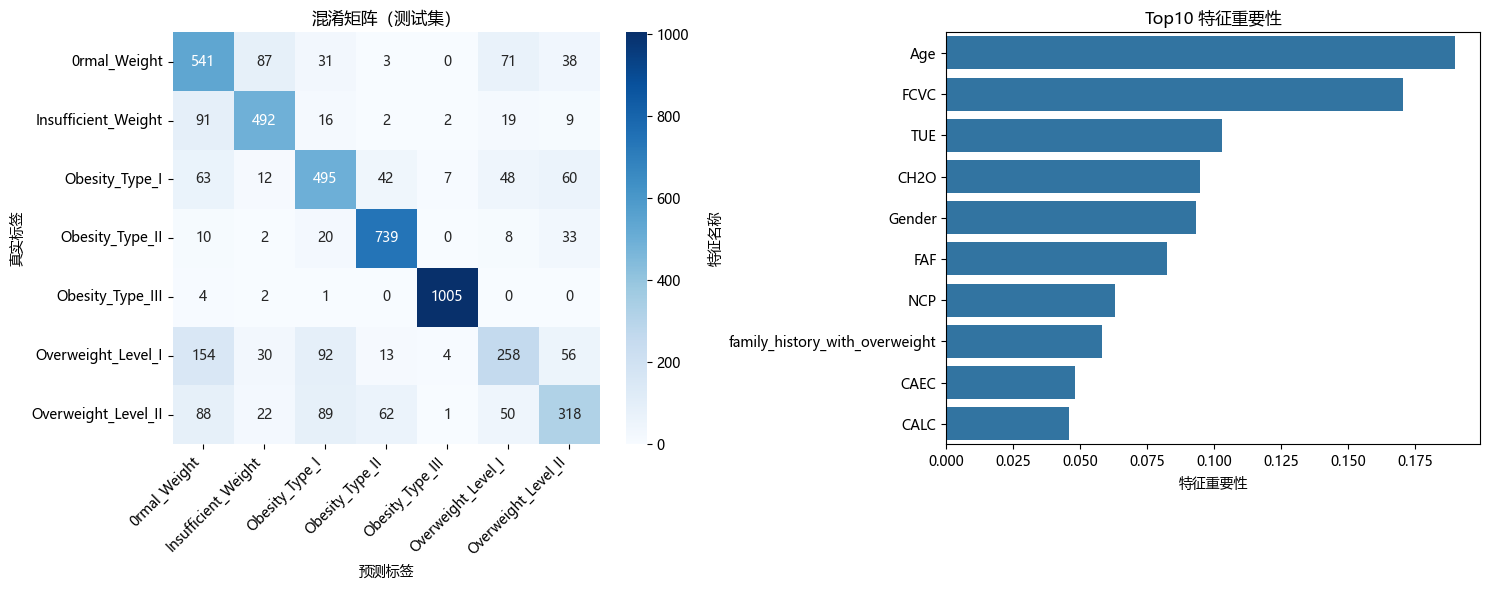

In [4]:
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# 解决中文路径和编码问题
os.environ['JOBLIB_TEMP_FOLDER'] = 'D:/temp_joblib'
if not os.path.exists(os.environ['JOBLIB_TEMP_FOLDER']):
    os.makedirs(os.environ['JOBLIB_TEMP_FOLDER'])

target_names = encoders['0be1dad'].classes_  # 目标变量原始类别名

# 1. 训练基准随机森林
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
baseline_rf.fit(X_train, y_train)
y_pred_baseline = baseline_rf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"测试集准确率：{baseline_acc:.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

# 2. 超参数调优（GridSearchCV）
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=1),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 提取最优模型和结果
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
y_pred = best_rf.predict(X_test)

print(f"\n调优结果：")
print(f"最优交叉验证准确率：{best_cv_score:.4f}")
print(f"最优超参数：{best_params}")

# 3. 最优模型详细评估
print("\n" + "="*50)
print("最优随机森林模型（调参后）评估")
print("="*50)
metrics = {
    '准确率': accuracy_score(y_test, y_pred),
    '精确率': precision_score(y_test, y_pred, average='macro'),
    '召回率': recall_score(y_test, y_pred, average='macro'),
    'F1分数': f1_score(y_test, y_pred, average='macro')
}
for name, value in metrics.items():
    print(f"{name}：{value:.4f}")

print("\n分类报告（按肥胖水平）：")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# 4. 结果可视化
plt.figure(figsize=(15, 6))

# 4.1 混淆矩阵
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=target_names, yticklabels=target_names 
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵（测试集）')

# 4.2 特征重要性（Top10）
plt.subplot(1, 2, 2)
feature_importance = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sns.barplot(
    x=feature_importance[sorted_idx][:10],
    y=X_train.columns[sorted_idx][:10]
)
plt.xlabel('特征重要性')
plt.ylabel('特征名称')
plt.title('Top10 特征重要性')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.preprocessing import StandardScaler  # 数据标准化
from sklearn.ensemble import RandomForestClassifier  # 随机森林
from sklearn.svm import SVC  # 支持向量机
from sklearn.neighbors import KNeighborsClassifier  # K近邻
from sklearn.tree import DecisionTreeClassifier  # 决策树
import joblib  # 用于保存模型
import time  # 用于计算训练时间

# 1. 数据标准化
# 标准化：将特征缩放到均值为0，标准差为1的分布
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # fit_transform：计算参数并转换数据

# 2. 定义要训练的模型
models = {
    '随机森林': RandomForestClassifier(
        n_estimators=100,        # 树的数量
        max_depth=10,            # 树的最大深度
        min_samples_split=5,     # 内部节点分裂所需最小样本数
        min_samples_leaf=2,      # 叶节点最少样本数
        random_state=42,         # 随机种子
        n_jobs=-1               # 使用所有CPU核心
    ),
    '支持向量机': SVC(
        kernel='rbf',            # 核函数：径向基函数
        C=1.0,                   # 正则化参数
        gamma='scale',           # 核函数系数
        random_state=42,         # 随机种子
        probability=True         # 启用概率估计
    ),
    'K近邻': KNeighborsClassifier(
        n_neighbors=5,           # 邻居数量
        weights='uniform',       # 权重：统一权重
        algorithm='auto'         # 算法自动选择
    ),
    '决策树': DecisionTreeClassifier(
        max_depth=10,            # 树的最大深度
        min_samples_split=5,     # 内部节点分裂所需最小样本数
        min_samples_leaf=2,      # 叶节点最少样本数
        random_state=42          # 随机种子
    )
}

# 3. 训练所有模型
trained_models = {}  # 存储训练好的模型
training_times = {}  # 存储每个模型的训练时间

for name, model in models.items():
    print(f"训练 {name}...")
    start_time = time.time()  # 记录开始时间
    
    # 训练模型
    model.fit(X_train, y_train)
    
    end_time = time.time()  # 记录结束时间
    training_time = end_time - start_time
    training_times[name] = training_time
    
    # 保存训练好的模型
    trained_models[name] = model
    
    print(f"  {name} 训练完成，耗时: {training_time:.2f} 秒")
    print(f"  训练集准确率: {model.score(X_train, y_train):.4f}")

训练 随机森林...
  随机森林 训练完成，耗时: 0.74 秒
  训练集准确率: 0.7952
训练 支持向量机...
  支持向量机 训练完成，耗时: 52.08 秒
  训练集准确率: 0.6086
训练 K近邻...
  K近邻 训练完成，耗时: 0.42 秒
  训练集准确率: 0.7537
训练 决策树...
  决策树 训练完成，耗时: 0.05 秒
  训练集准确率: 0.7452


In [6]:
"""
模型评估模块
功能：评估所有训练好的模型性能，比较准确率、生成分类报告和混淆矩阵
"""
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, precision_recall_fscore_support)

# 存储每个模型的评估结果
results = {}
detailed_metrics = []

for name, model in trained_models.items():
    print(f"\n评估 {name}...")
    
    # 在测试集上进行预测
    y_pred = model.predict(X_test)
    
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    
    # 计算精确率、召回率、F1分数（按类别）
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    # 计算宏平均和加权平均
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted')
    
    # 存储结果
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }
    
    # 存储详细指标
    for i, class_label in enumerate(np.unique(y_test)):
        detailed_metrics.append({
            'Model': name,
            'Class': class_label,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1[i],
            'Support': support[i]
        })

# 性能比较和排名
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision_Macro': [results[name]['precision_macro'] for name in results.keys()],
    'Recall_Macro': [results[name]['recall_macro'] for name in results.keys()],
    'F1_Macro': [results[name]['f1_macro'] for name in results.keys()],
    'F1_Weighted': [results[name]['f1_weighted'] for name in results.keys()]
})

# 按准确率降序排列
performance_df = performance_df.sort_values('Accuracy', ascending=False)
print(performance_df.round(4))



评估 随机森林...

评估 支持向量机...

评估 K近邻...

评估 决策树...
   Model  Accuracy  Precision_Macro  Recall_Macro  F1_Macro  F1_Weighted
0   随机森林    0.7391           0.7204        0.7088    0.7062       0.7313
3    决策树    0.6861           0.6616        0.6524    0.6513       0.6814
2    K近邻    0.6653           0.6321        0.6324    0.6263       0.6547
1  支持向量机    0.6040           0.5617        0.5639    0.5431       0.5770
